## Setup

In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.7.0
• GPU Device Found.


## Read the processed data into the training dataset and validation dataset
The data in this directory has been previously cleaned, which finally obtained a dataset of 350 images in each class which is divided into 2 directories in the training directory as much as 80% or 280 images in each class and in the Validation or Test data as much as 20% or 70 images in each class.

In [3]:
TRAINING_DIR = "train_dir/"
VALIDATION_DIR = "validation_dir/"

In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale= 1./255.,
                                        rotation_range=180,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,             
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode="categorical",
                                                        target_size=(299, 299))

    
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode="categorical",
                                                                  target_size=(299, 299))
    
    return train_generator, validation_generator

In [5]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [6]:
label_names = list(validation_generator.class_indices.keys())
print(f"{label_names} \nClass : {len(label_names)}")

['American_shorthair', 'Basset_hound', 'Beagle', 'Bengal', 'Boxer', 'British_Shorthair', 'Chihuahua', 'English_cocker_spaniel', 'Japanese_chin', 'Maine_Coon', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian_Blue', 'Samoyed', 'Scottish_fold', 'Siamese', 'Sphynx'] 
Class : 20


In [7]:
def plotImages(images_arr, folder_names):
    fig, axes = plt.subplots(1, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, folder_name, ax in zip(images_arr, folder_names, axes):
        ax.imshow(img[:, :, 0])
        ax.axis('off')
        ax.set_title(folder_name)
    plt.tight_layout()
    plt.show()

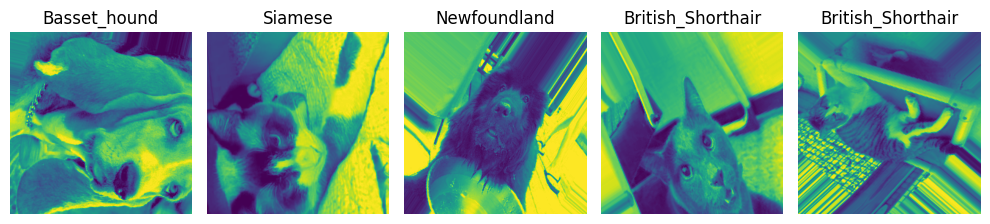

In [8]:
sample_training_images, labels = next(train_generator)
folder_names = [list(train_generator.class_indices.keys())[label.argmax()] for label in labels]

plotImages(sample_training_images[:5], folder_names)

## Creating a Callback class

In [9]:
class cb(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
            print("\nAccuracy has reached above 97%, training stops")
            self.model.stop_training = True # training will stop when accuracy and val_accuracy have reached >= 97%

callbacks = cb()

## Define, compile and Train the model

In [10]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299) and output dimension 2048


In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE])

In [12]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),     
        tf.keras.layers.Dense(20,activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 22,920,116
Trainable params: 1,117,332
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
# Train the model
history = model.fit(train_generator,
                    epochs=200,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                   )

Epoch 1/200
175/175 [==============================] - 105s 555ms/step - loss: 1.7709 - accuracy: 0.5268 - val_loss: 0.8135 - val_accuracy: 0.7843
Epoch 2/200
175/175 [==============================] - 96s 549ms/step - loss: 0.9917 - accuracy: 0.6877 - val_loss: 0.5825 - val_accuracy: 0.8321
Epoch 3/200
175/175 [==============================] - 97s 551ms/step - loss: 0.8628 - accuracy: 0.7114 - val_loss: 0.5176 - val_accuracy: 0.8493
Epoch 4/200
175/175 [==============================] - 97s 555ms/step - loss: 0.8180 - accuracy: 0.7254 - val_loss: 0.4823 - val_accuracy: 0.8536
Epoch 5/200
175/175 [==============================] - 96s 549ms/step - loss: 0.7793 - accuracy: 0.7370 - val_loss: 0.4971 - val_accuracy: 0.8386
Epoch 6/200
175/175 [==============================] - 97s 553ms/step - loss: 0.7536 - accuracy: 0.7439 - val_loss: 0.4569 - val_accuracy: 0.8586
Epoch 7/200
175/175 [==============================] - 96s 551ms/step - loss: 0.7225 - accuracy: 0.7575 - val_loss: 0.4576 

Epoch 57/200
175/175 [==============================] - 90s 511ms/step - loss: 0.4413 - accuracy: 0.8429 - val_loss: 0.4433 - val_accuracy: 0.8564
Epoch 58/200
175/175 [==============================] - 90s 515ms/step - loss: 0.4269 - accuracy: 0.8479 - val_loss: 0.4075 - val_accuracy: 0.8629
Epoch 59/200
175/175 [==============================] - 92s 526ms/step - loss: 0.4209 - accuracy: 0.8523 - val_loss: 0.3892 - val_accuracy: 0.8693
Epoch 60/200
175/175 [==============================] - 91s 517ms/step - loss: 0.4171 - accuracy: 0.8587 - val_loss: 0.3919 - val_accuracy: 0.8721
Epoch 61/200
175/175 [==============================] - 92s 525ms/step - loss: 0.4044 - accuracy: 0.8548 - val_loss: 0.4303 - val_accuracy: 0.8614
Epoch 62/200
175/175 [==============================] - 92s 524ms/step - loss: 0.4084 - accuracy: 0.8559 - val_loss: 0.4321 - val_accuracy: 0.8579
Epoch 63/200
175/175 [==============================] - 91s 519ms/step - loss: 0.4158 - accuracy: 0.8541 - val_loss: 0

175/175 [==============================] - 91s 520ms/step - loss: 0.3013 - accuracy: 0.8938 - val_loss: 0.4011 - val_accuracy: 0.8721
Epoch 113/200
175/175 [==============================] - 91s 520ms/step - loss: 0.3003 - accuracy: 0.8979 - val_loss: 0.4297 - val_accuracy: 0.8643
Epoch 114/200
175/175 [==============================] - 91s 519ms/step - loss: 0.3067 - accuracy: 0.8950 - val_loss: 0.4184 - val_accuracy: 0.8707
Epoch 115/200
175/175 [==============================] - 91s 519ms/step - loss: 0.2912 - accuracy: 0.8998 - val_loss: 0.4251 - val_accuracy: 0.8664
Epoch 116/200
175/175 [==============================] - 91s 520ms/step - loss: 0.3047 - accuracy: 0.8934 - val_loss: 0.4198 - val_accuracy: 0.8671
Epoch 117/200
175/175 [==============================] - 91s 521ms/step - loss: 0.2773 - accuracy: 0.9032 - val_loss: 0.3937 - val_accuracy: 0.8707
Epoch 118/200
175/175 [==============================] - 91s 522ms/step - loss: 0.2965 - accuracy: 0.8977 - val_loss: 0.4113 -

175/175 [==============================] - 92s 524ms/step - loss: 0.2239 - accuracy: 0.9211 - val_loss: 0.4268 - val_accuracy: 0.8629
Epoch 168/200
175/175 [==============================] - 91s 519ms/step - loss: 0.2063 - accuracy: 0.9300 - val_loss: 0.5124 - val_accuracy: 0.8514
Epoch 169/200
175/175 [==============================] - 91s 520ms/step - loss: 0.2146 - accuracy: 0.9284 - val_loss: 0.4236 - val_accuracy: 0.8650
Epoch 170/200
175/175 [==============================] - 91s 521ms/step - loss: 0.2013 - accuracy: 0.9329 - val_loss: 0.4235 - val_accuracy: 0.8700
Epoch 171/200
175/175 [==============================] - 91s 519ms/step - loss: 0.2048 - accuracy: 0.9320 - val_loss: 0.4612 - val_accuracy: 0.8557
Epoch 172/200
175/175 [==============================] - 91s 522ms/step - loss: 0.2150 - accuracy: 0.9262 - val_loss: 0.4798 - val_accuracy: 0.8543
Epoch 173/200
175/175 [==============================] - 91s 518ms/step - loss: 0.2079 - accuracy: 0.9268 - val_loss: 0.4894 -

### Evaluate the Model

In [37]:
# Evaluate the model on the test or validation images.
results_eval = model.evaluate(validation_generator)

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

44/44 [==============================] - 4s 88ms/step - loss: 0.4849 - accuracy: 0.8564
loss: 0.485
accuracy: 0.856


### Training History

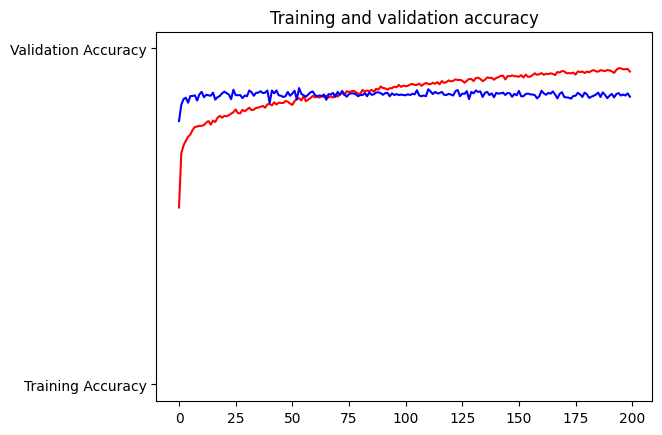

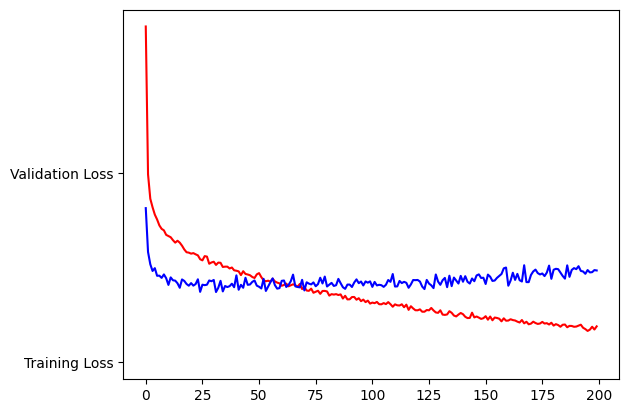

In [38]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## save model format Keras HDF5

In [39]:
model.save('model_percobaan2_Inceptionv3.h5')

## Save model Exporting to TFLite

In [40]:
export_dir = 'saved_model/model_percobaan2_Inceptionv3'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/model_percobaan2_Inceptionv3\assets


INFO:tensorflow:Assets written to: saved_model/model_percobaan2_Inceptionv3\assets


In [41]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [42]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [43]:
tflite_model_file = pathlib.Path('./model_percobaan2_Inceptionv3.tflite')
tflite_model_file.write_bytes(tflite_model)

23366280